[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/w

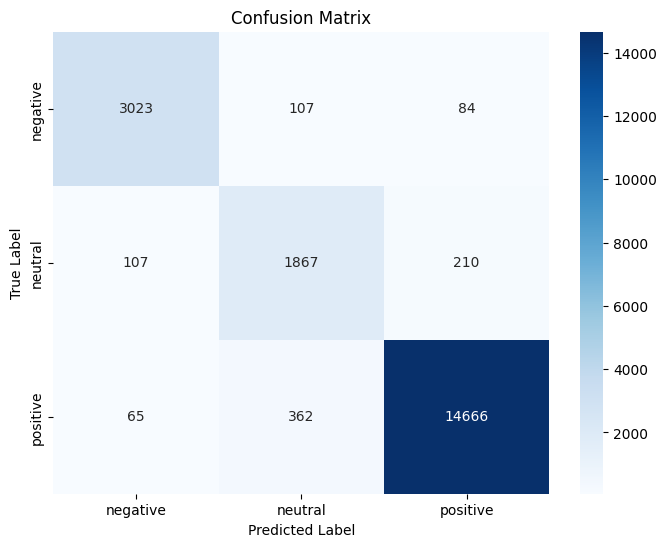

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import Word2Vec
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import normalize
import math
import multiprocessing
import time

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
data_path = '/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv'
data = pd.read_csv(data_path)

# Preprocessing: Text Cleaning, Tokenization, and Normalization
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['Cleaned_Review'] = data['Review'].apply(preprocess_text)

# Create sentiment labels from ratings
def rating_to_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

data['Sentiment'] = data['Rating'].apply(rating_to_sentiment)

# Convert 'Sentiment' column to category
data['Sentiment'] = data['Sentiment'].astype('category')

# Train Word2Vec model
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

sentences = [nltk.word_tokenize(text) for text in data['Cleaned_Review']]
t = time.time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

t = time.time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

# Convert text data to Word2Vec vectors (average of word vectors)
def text_to_vector(text):
    tokens = nltk.word_tokenize(text.lower())
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

vectors = np.array([text_to_vector(text) for text in data['Cleaned_Review']])

# Normalize vectors
vectors = normalize(vectors, axis=1)

# Define Attention mechanism
class Attention(nn.Module):
    def __init__(self, query_dim, key_dim, value_dim):
        super(Attention, self).__init__()
        self.scale = 1. / math.sqrt(query_dim)

    def forward(self, query, keys, values):
        query = query.unsqueeze(1)
        keys = keys.permute(0, 2, 1)
        energy = torch.bmm(query, keys)
        energy = torch.nn.functional.softmax(energy.mul_(self.scale), dim=2)
        linear_combination = torch.bmm(energy, values).squeeze(1)
        return energy, linear_combination

# Define BiLSTM with attention model
class SentimentBiLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SentimentBiLSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size * 2, hidden_size * 2, hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        bilstm_out, (hn, cn) = self.bilstm(x)
        bilstm_out = bilstm_out.contiguous()
        query = hn.transpose(0, 1).contiguous().view(x.size(0), -1)
        keys = bilstm_out
        values = bilstm_out
        energy, linear_combination = self.attention(query, keys, values)
        output = self.fc(linear_combination)
        return output

# Cross-validation and hyperparameter tuning
def cross_validate_and_tune(vectors, labels, num_folds=5, num_epochs=20):
    skf = StratifiedKFold(n_splits=num_folds)
    best_model = None
    best_acc = 0.0
    
    for num_evaluation, (train_index, val_index) in enumerate(skf.split(vectors, labels)):
        X_train, X_val = vectors[train_index], vectors[val_index]
        y_train, y_val = labels[train_index], labels[val_index]

        # Apply SMOTE to the training data
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        # Convert to tensors
        X_train_tensor = torch.tensor(X_train_smote, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(pd.Series(y_train_smote).cat.codes.values, dtype=torch.long).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(pd.Series(y_val).cat.codes.values, dtype=torch.long).to(device)
        
        # Define parameters
        input_size = 300
        hidden_size = 128
        output_size = len(data['Sentiment'].unique())
        
        # Calculate class weights
        class_counts = Counter(y_train_smote)
        total_samples = len(y_train_smote)
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        class_weights_tensor = torch.tensor([class_weights[cls] for cls in sorted(class_counts.keys())], dtype=torch.float32).to(device)
        
        # Create BiLSTM with attention model instance
        bilstm_attention_model = SentimentBiLSTMWithAttention(input_size, hidden_size, output_size).to(device)

        # Define optimizer and loss function
        optimizer = optim.Adam(bilstm_attention_model.parameters(), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
        
        # Define DataLoader
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

        # Training loop
        def train_model(model, train_loader, optimizer, loss_fn, num_epochs):
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct_predictions = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()

                epoch_loss = running_loss / len(train_loader.dataset)
                epoch_acc = correct_predictions / len(train_loader.dataset)
                print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            return model

        # Train the model
        trained_model = train_model(bilstm_attention_model, train_loader, optimizer, loss_fn, num_epochs)

        # Evaluate the model
        def evaluate_model(model, X_val_tensor, y_val_tensor):
            model.eval()
            with torch.no_grad():
                outputs = model(X_val_tensor)
                acc = (outputs.argmax(dim=1) == y_val_tensor).sum().item() / len(y_val_tensor)
                cm = confusion_matrix(y_val_tensor.cpu(), outputs.argmax(dim=1).cpu())
                cr = classification_report(y_val_tensor.cpu(), outputs.argmax(dim=1).cpu(), target_names=['negative', 'neutral', 'positive'])
            return acc, cm, cr

        val_acc, val_cm, val_cr = evaluate_model(trained_model, X_val_tensor, y_val_tensor)
        print(f'\n Validation {num_evaluation + 1}/{num_folds}, Validation Accuracy: {val_acc:.4f}')
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = trained_model
    return best_model

# Perform cross-validation and get the best model
labels = data['Sentiment']
best_model = cross_validate_and_tune(vectors, labels)

# Final evaluation on test set
def final_evaluation(model, test_vectors_tensor, test_labels_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(test_vectors_tensor)
        acc = (outputs.argmax(dim=1) == test_labels_tensor).sum().item() / len(test_labels_tensor)
        cm = confusion_matrix(test_labels_tensor.cpu(), outputs.argmax(dim=1).cpu())
        cr = classification_report(test_labels_tensor.cpu(), outputs.argmax(dim=1).cpu(), target_names=['negative', 'neutral', 'positive'])
    return acc, cm, cr

# Convert test data to tensors
test_vectors_tensor = torch.tensor(vectors, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(labels.cat.codes.values, dtype=torch.long).to(device)

# Evaluate the best model on the entire test set
final_acc, final_cm, final_cr = final_evaluation(best_model, test_vectors_tensor, test_labels_tensor)
print(f"Final Test Accuracy: {final_acc:.4f}")
print("Final Confusion Matrix:")
print(final_cm)
print("\nFinal Classification Report:")
print(final_cr)

# Confusion Matrix Visualization
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(final_cm, ['negative', 'neutral', 'positive'])
